# Основная программа

In [101]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/lera/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [102]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
import scipy.interpolate as inter
from matplotlib import cm

In [103]:
import functions

In [104]:
Distance = 10.57 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [105]:

def cut_fits(first_fits=None, second_fits=None, size=None):
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2)
    cposition1 = SkyCoord('170.06318266 12.99640067'.format(first_WCS.wcs.crval[0], first_WCS.wcs.crval[1]), frame='icrs', unit='deg')
    
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    cposition2 = SkyCoord('{} {}'.format(second_WCS.wcs.crval[0], second_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition2, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition2, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

In [106]:
def create_new_grid(first_fits=None, second_fits=None, size=None):
    first_data, second_data = cut_fits(first_fits=first_fits, second_fits=second_fits, size=size)
    shape = first_data.shape
    first_data_wcs = first_data.wcs
    X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
    sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data_wcs).reshape((shape[0], shape[1]))
    
    grid_pixs = []
    new_second_data = []
    for scoord in sgrid.ravel():
        spix = skycoord_to_pixel(scoord, second_data.wcs)
        grid_pixs.append(spix)
        new_second_data.append(second_data.data[int(spix[1])][int(spix[0])])
    
    return grid_pixs, new_second_data  

### Разберёмся с данными из VENGA

## $\sigma_s$



In [107]:
def cut_fits_for_sigmaS(first_fits=None, second_fits=None, size=None):
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2)
    cposition1 = SkyCoord('170.06318266 12.99640067'.format(first_WCS.wcs.crval[0], first_WCS.wcs.crval[1]), frame='icrs', unit='deg')
    
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    cposition2 = SkyCoord('{} {}'.format(second_WCS.wcs.crval[0], second_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition1, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition1, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

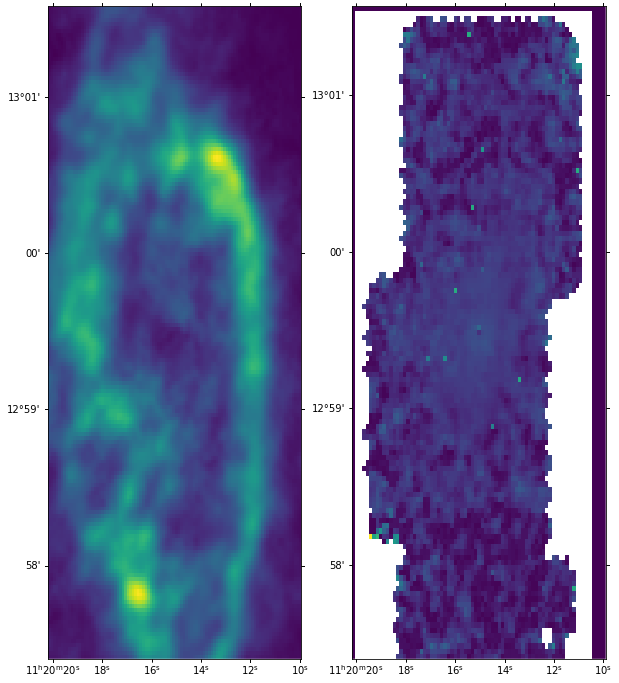

(167, 100)
(125, 75)


In [108]:
size = [250,150]
sigma_s, second = cut_fits(first_fits = './data/NGC3627_map_sigstar.fits', second_fits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 

fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=second.wcs)

ax.imshow(second.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=sigma_s.wcs)
ax2.imshow(sigma_s.data, origin='lower', aspect="auto")

plt.show()

print(second.shape)
print(sigma_s.shape)



## $\Sigma_{HI}$

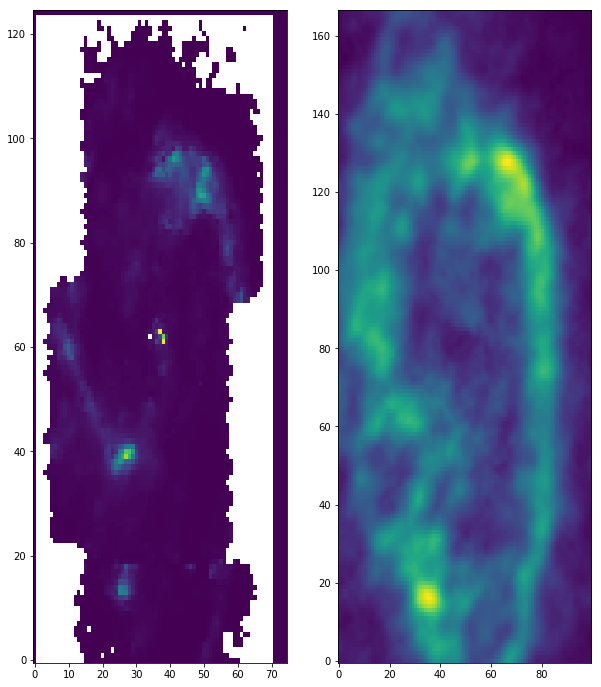

(125, 75)
(167, 100)


In [110]:
size = [250,150] # обратите внимание, что это в угловых секундах, а не в пикселях
first_data, second_data = cut_fits(first_fits='./data/NGC3627_map_ha_corr.fits', second_fits='./data/NGC_3627_NA_MOM0_THINGS.FITS', size=size) 

fig, [ax, ax2] = plt.subplots(figsize=[10, 12], ncols=2)
ax.imshow(first_data.data, origin='lower', aspect="auto")
ax2.imshow(second_data.data, origin='lower', aspect="auto")
plt.show()

print(first_data.shape)
print(second_data.shape)  

То же самое, но не в пикселях, а с небесными координатами:

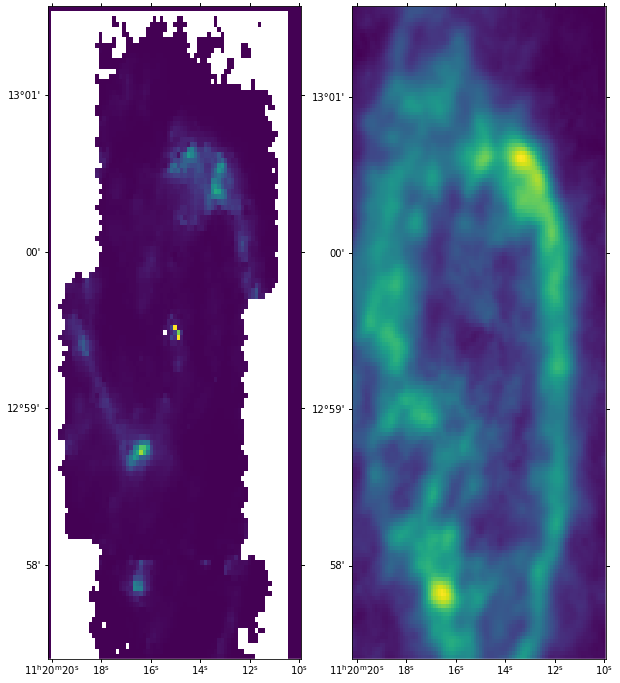

(125, 75)
(167, 100)


In [111]:
size = [250,150]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 
fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")

plt.show()

print(first_data.shape)
print(second_data.shape)  

Видно, что все как и должно быть - например по вертикали 300 угловых секунд, т.е. 5 минут - и вот они, как раз на y-оси отмечены.

In [112]:
size = [250,150]
grid_pix, Sigma_HI = create_new_grid(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 


In [113]:
Sigma_HI = np.array(Sigma_HI).reshape(125,75)

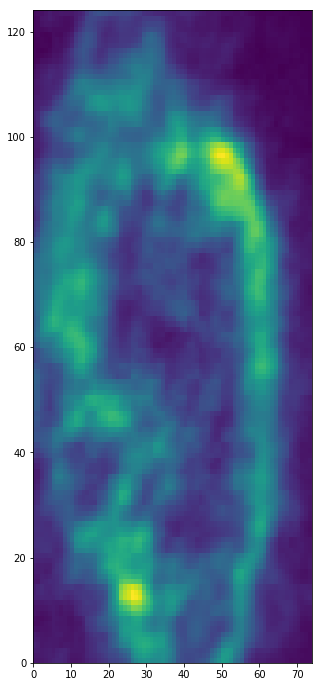

In [114]:
fig = plt.figure(figsize = [5,12])
Z = Sigma_HI
X, Y = np.meshgrid(np.arange(0,75,1), np.arange(0,125,1))
plt.pcolormesh(X, Y, Z)

In [68]:
np.save('Sigma_HI.npy',Sigma_HI)

## $\sigma_{HI}$

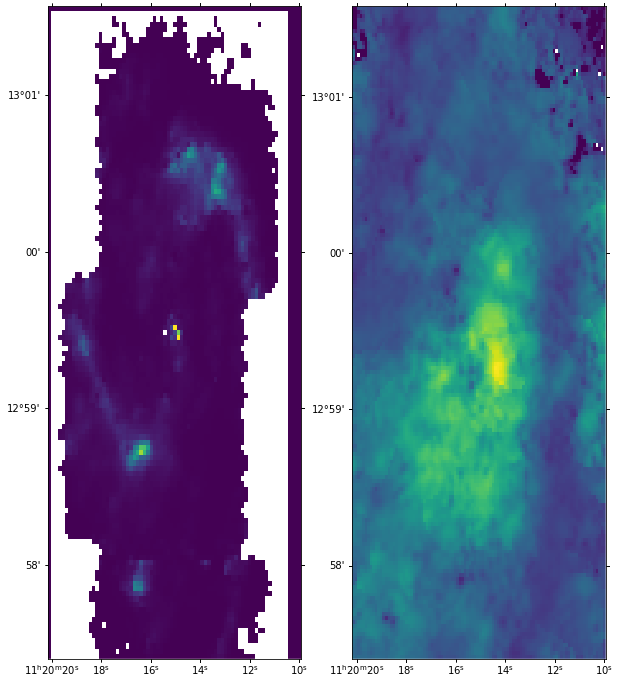

(125, 75)
(167, 100)


In [116]:
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM2_THINGS.FITS', size = size)
fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")

plt.show()

print(first_data.shape)
print(second_data.shape)

In [117]:
size = [250,150]
grid_pix, sigma_HI = create_new_grid(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM2_THINGS.FITS', size = size) 

In [118]:
sigma_HI = np.array(sigma_HI).reshape(125,75)

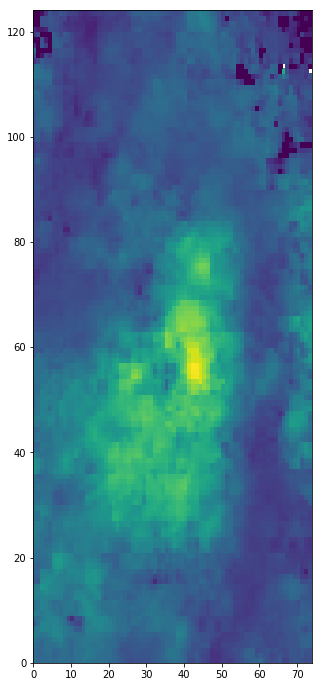

In [119]:
fig = plt.figure(figsize = [5,12])
Z = sigma_HI
X, Y = np.meshgrid(np.arange(0,75,1), np.arange(0,125,1))
plt.pcolormesh(X, Y, Z)

In [73]:
np.save('sigma_HI.npy', sigma_HI)

## $H_\alpha$ & $I_{CO}$

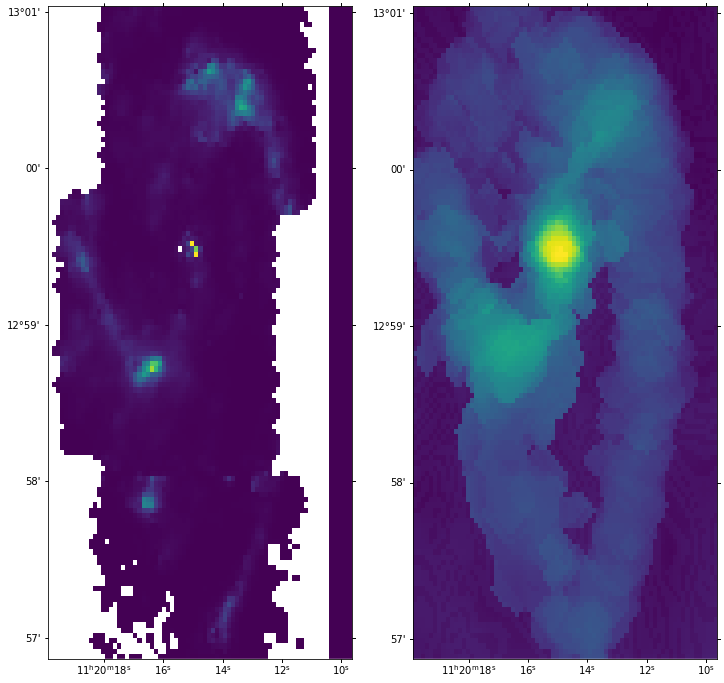

(125, 75)
(125, 75)


In [120]:
size = [250,150]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/ngc3627_emom0_I_CO_J1-2_lwb2009.fits', size = size)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")



plt.show()

print(first_data.shape)
print(second_data.shape)

In [121]:
I_CO = np.array(second_data.data).reshape(125,75)

In [122]:
H_alpha = np.array(first_data.data).reshape(125,75) 

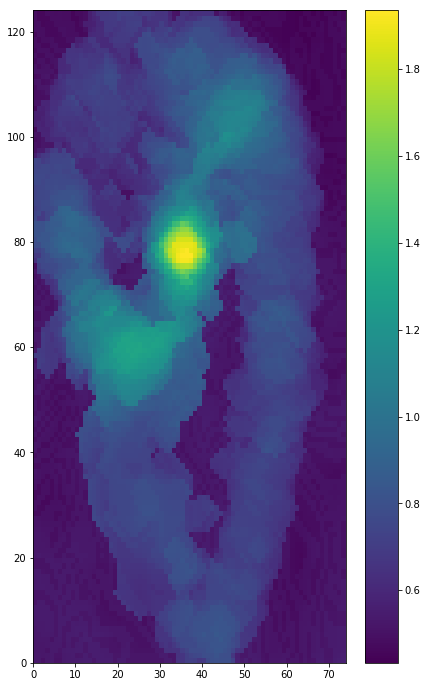

In [123]:
fig = plt.figure(figsize = [7,12])
Z = I_CO
X, Y = np.meshgrid(np.arange(0,75,1), np.arange(0,125,1))
picture=plt.pcolormesh(X,Y,Z)
plt.colorbar()
plt.show()

Получим $\Sigma_{H2}$ из $I_{CO}$: 
$$\Sigma_{H_2} = 5.5\cos i \times I_{CO(2-1)}$$

In [124]:
Sigma_H2 = 5.5 * cosi * I_CO

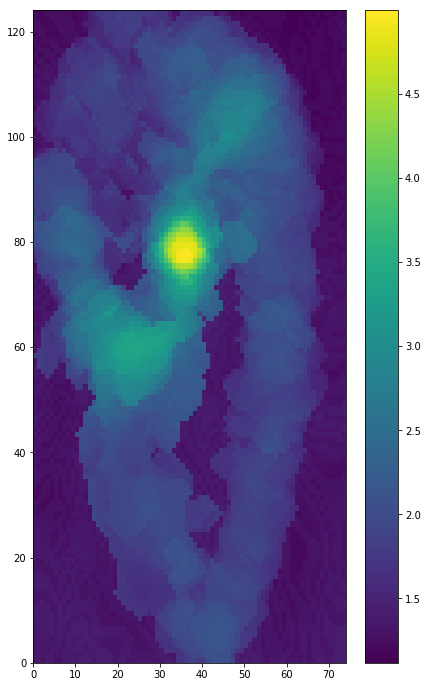

In [125]:
fig = plt.figure(figsize = [7,12])
Z = Sigma_H2
X, Y = np.meshgrid(np.arange(0,75,1), np.arange(0,125,1))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

## $\Sigma_s$

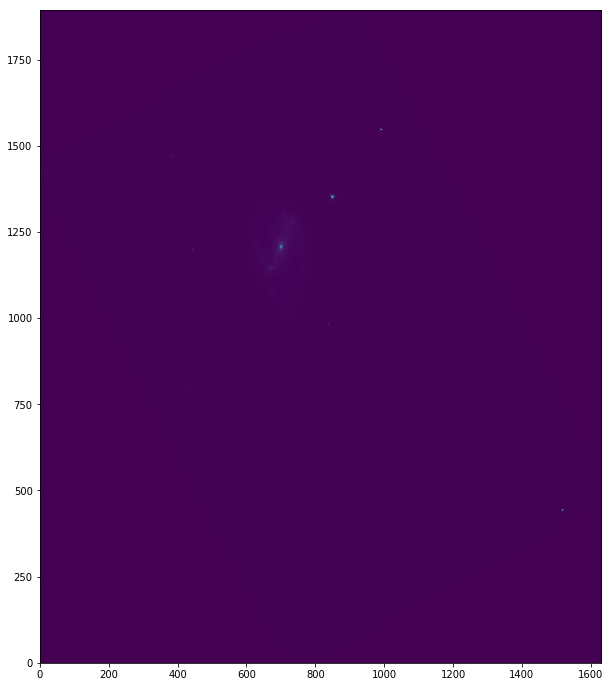

In [126]:
functions.fits_file('./data/NGC3627.phot.1_nonan.fits', 12, 12)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


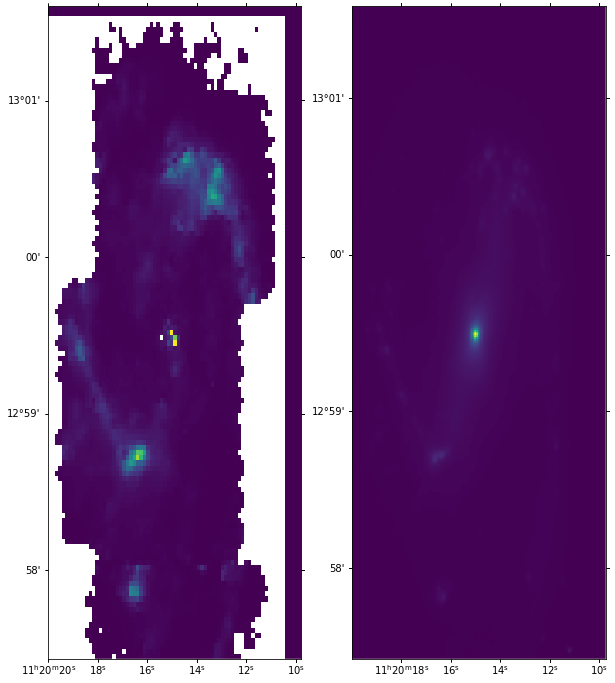

(125, 75)
(333, 200)


In [127]:
size = [250,150]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size) 
fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")

plt.show()

print(first_data.shape)
print(second_data.shape)  

In [128]:
def create_new_grid_for_SigmaS(first_fits=None, second_fits=None, size=None):
    first_data, second_data = cut_fits(first_fits=first_fits, second_fits=second_fits, size=size)
    shape = first_data.shape
    first_data_wcs = first_data.wcs
    X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
    sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data_wcs).reshape((shape[0], shape[1]))
    
    grid_pixs = []
    new_second_data = []
    for scoord in sgrid.ravel():
        spix = skycoord_to_pixel(scoord, second_data.wcs)
       
        if (spix[1]<332):
            grid_pixs.append(spix)
            new_second_data.append(second_data.data[int(spix[1])][int(spix[0])] * 280. * cosi)
    
    return grid_pixs, new_second_data  

In [129]:
size = [250,150]
grid_pix, Sigma_s = create_new_grid_for_SigmaS(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size) 

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [130]:
len(grid_pix)

9300

!!!Пришлось обрезать по одному пикселю сверху, иначе не компелировалось(

In [131]:
Sigma_s = np.array(Sigma_s).reshape(124,75)

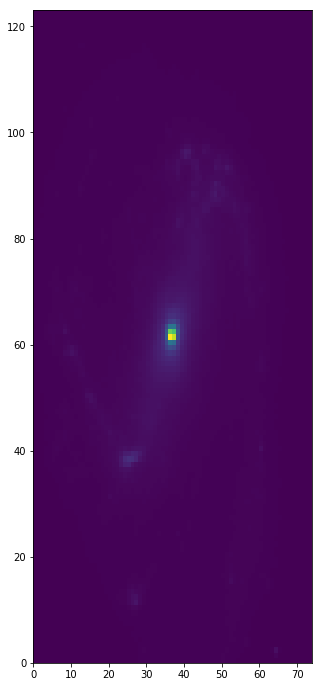

In [132]:
fig = plt.figure(figsize = [5,12])
Z = Sigma_s
X, Y = np.meshgrid(np.arange(0,75,1), np.arange(0,124,1))
plt.pcolormesh(X, Y, Z)

Соберём все полученные данные в общую картину

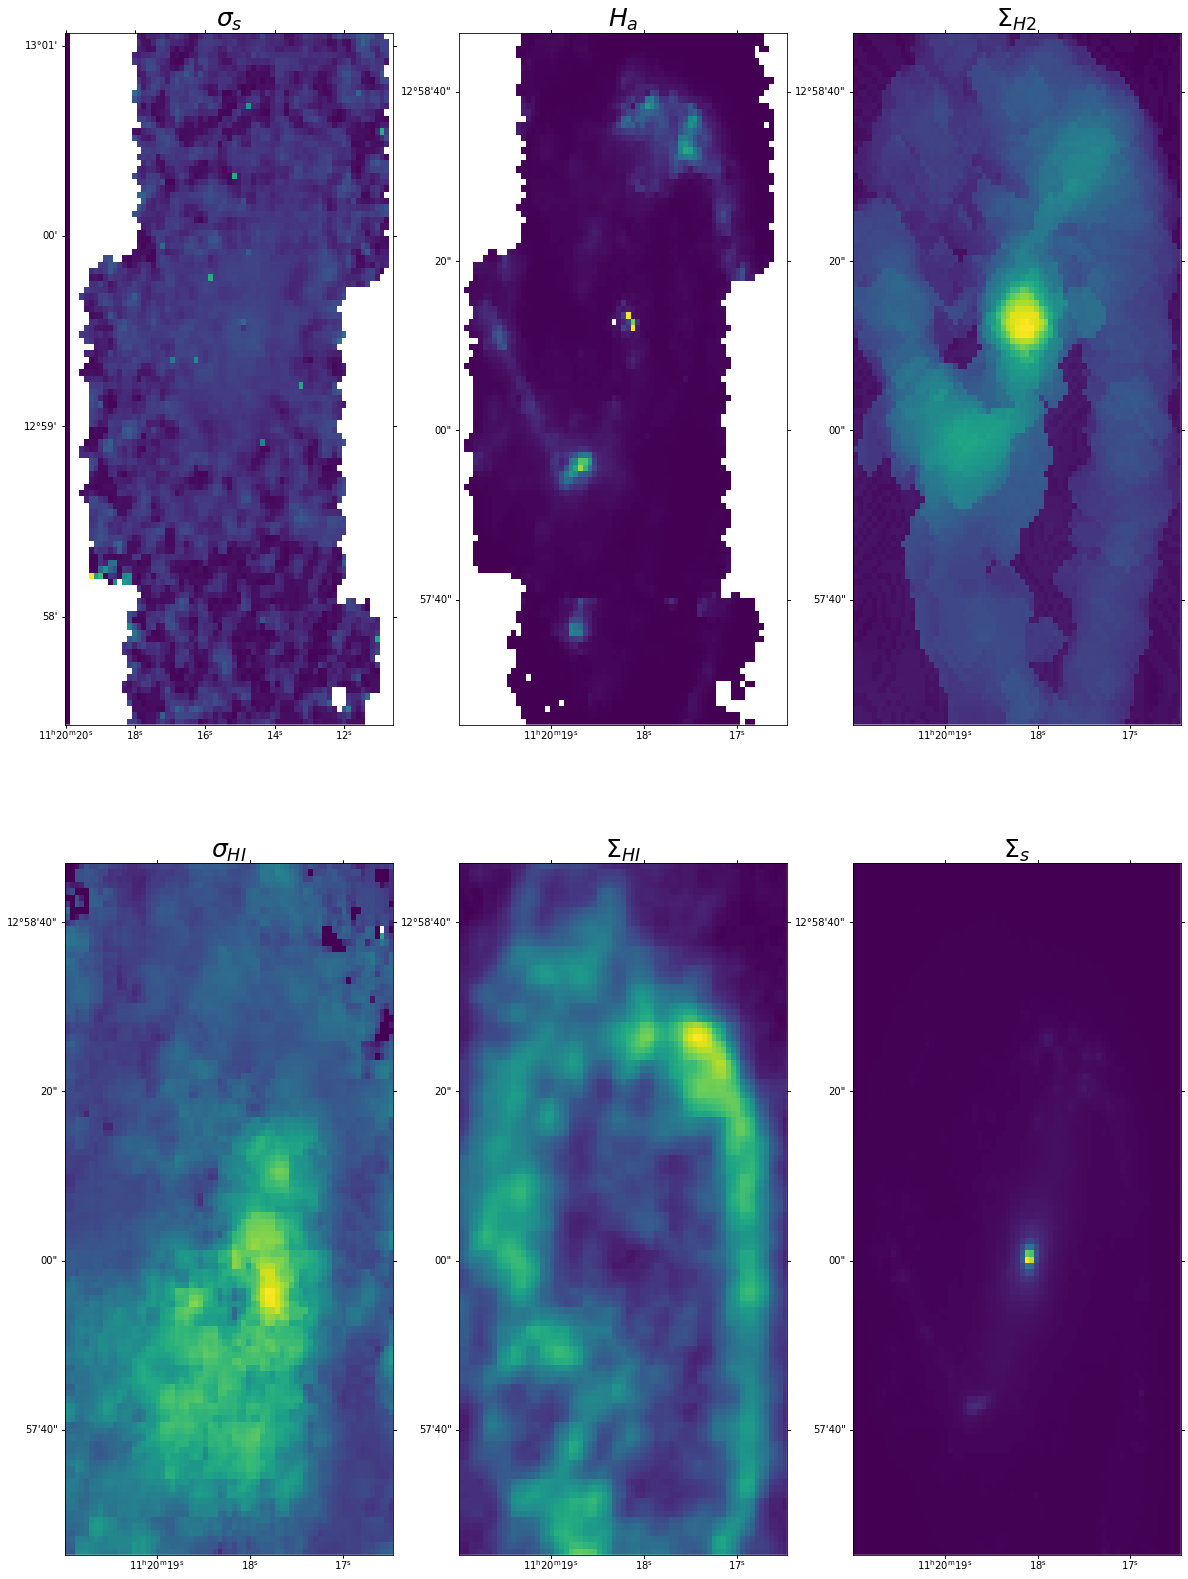

(125, 75)
(109, 69) (125, 75)
(109, 69) (125, 75)
(109, 69) (125, 75)
(109, 69) (125, 75)
(109, 69) (124, 75)


In [139]:
fig = plt.figure(figsize=[20, 28])
ax1 = fig.add_subplot(231, projection=first_data.wcs)
#sigma_s_cut = sigma_s[0:-6,0:]
ax1.imshow(sigma_s.data[0:-16,0:-6], origin='lower', aspect="auto")
plt.title('$\sigma_s$', fontsize=25)

ax2 = fig.add_subplot(232, projection=second_data.wcs)
H_alpha_cut = H_alpha[15:-1,0:-6]
ax2.imshow(H_alpha_cut.data, origin='lower', aspect="auto")
plt.title('$H_a$', fontsize=25)

ax3 = fig.add_subplot(233, projection=second_data.wcs)
Sigma_H2_cut = Sigma_H2[15:-1,0:-6]
ax3.imshow(Sigma_H2_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{H2}$', fontsize=25)

ax4 = fig.add_subplot(234, projection=second_data.wcs)
sigma_HI_cut = sigma_HI[15:-1,0:-6]
ax4.imshow(sigma_HI_cut.data,origin='lower', aspect="auto")
plt.title('$\sigma_{HI}$', fontsize=25)

ax5 = fig.add_subplot(235, projection=second_data.wcs)#
Sigma_HI_cut = Sigma_HI[15:-1,0:-6] 
ax5.imshow(Sigma_HI_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{HI}$', fontsize=25)

ax6 = fig.add_subplot(236, projection=second_data.wcs)
Sigma_s_cut = Sigma_s[15:,0:-6]
ax6.imshow(Sigma_s_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{s}$', fontsize=25)

plt.show()
print(sigma_s.shape)
print(H_alpha_cut.shape, H_alpha.shape)
print(Sigma_H2_cut.shape, Sigma_H2.shape)
print(sigma_HI_cut.shape, sigma_HI.shape)
print(Sigma_HI_cut.shape, Sigma_HI.shape)
print(Sigma_s_cut.shape, Sigma_s.shape)

## Velocity curve

In [62]:
from IPython.display import Image

Velocity curve из этой статьи https://arxiv.org/pdf/1808.07483.pdf


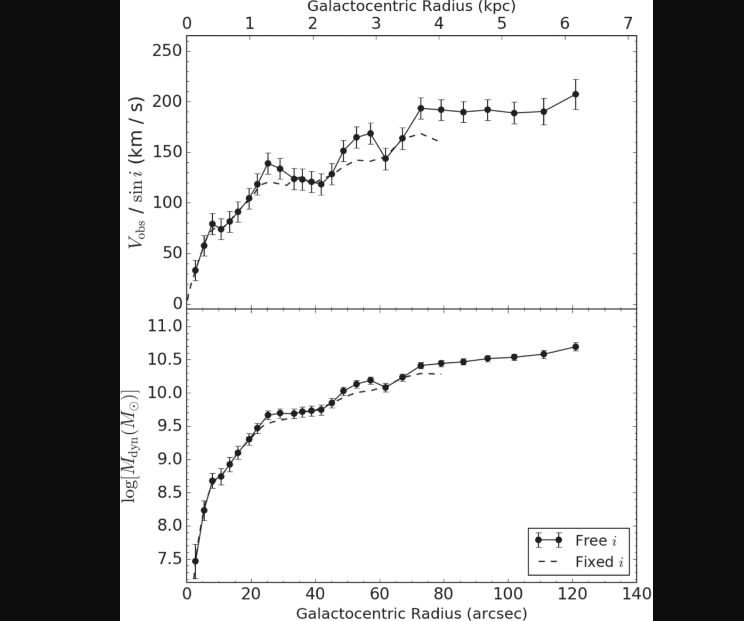

In [63]:
Image(filename='./images/velocity_curve.png')

 В статье написано
 > the freely-varying inclination iteration more closely recovers the expected PA = 178◦ of NGC 3627
 
 поэтому могу считать,что эта кривая соответствуют кривой вращения с P.A.=178 

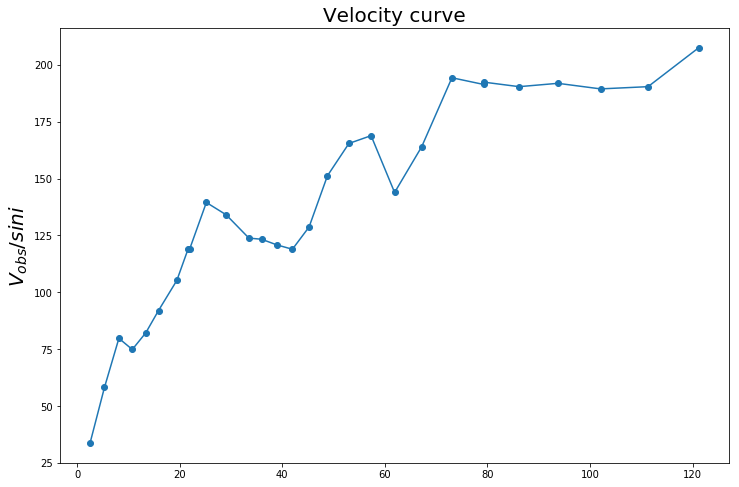

In [64]:
file_in=open('velocity_curve.dat','r')
data = file_in.readlines()
x = []
y = []
for i in data:
    x.append(float(i.split()[0]))
    y.append(float(i.split()[1])) 
fig = plt.figure(figsize = [12,8])     
plt.plot(x ,y,'o-')
plt.title('Velocity curve',fontsize = 20)
plt.ylabel('$V_{obs} / sin i$',fontsize = 20)
plt.show()

Переведём arcsec в kpc



In [65]:
rad = [r * np.pi / (180 *3600) * Distance * 10**3 for r in x] 

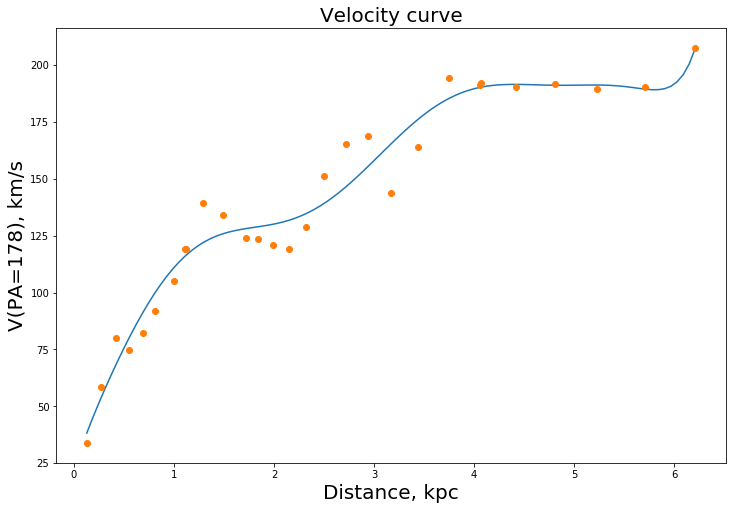

In [66]:
#Проинтерполируем 
vel = y

points = np.linspace(min(rad), max(rad), 100)
velocity_approx = poly1d(polyfit(rad, vel, deg=9))
fig = plt.figure(figsize = [12,8])     
line = plt.plot(points, velocity_approx(points))
line1 = plt.plot(rad, vel, 'o')
plt.title('Velocity curve',fontsize = 20)
plt.ylabel('V(PA=178), km/s', fontsize = 20)
plt.xlabel('Distance, kpc', fontsize = 20)
plt.show()


In [48]:
#file_in=open('result.dat','r') #Просто интерполяция сплайном из вычей
#data = file_in.readlines()
#x = []
#y = []
#for i in data:
#    x.append(float(i.split()[0]))
#    y.append(float(i.split()[1])) 
#fig = plt.figure(figsize = [12,8])     
#line = plt.plot(x ,y)
#line1 = plt.plot(dist, vel,'o')
#plt.title('Velocity curve',fontsize = 20)
#plt.ylabel('$V_{obs} / sin i$',fontsize = 20)
#plt.show()

Найдём эпициклическую частоту


In [ ]:
dR = (max(rad) - min(rad)) / 20
kappa = [functions.epic_freq(velocity_approx, r, dR) for r in points]

fig = plt.figure(figsize = [12,8])     
plt.plot(points, kappa) 
plt.title('Epicyclic frequency',fontsize = 20)
plt.ylabel('$\kappa$, km/s/kpc', fontsize = 18)
plt.xlabel('Distance, kpc', fontsize = 18)
plt.show()